# <center><font color=	DarkRed>Construire un modèle de scoring</font></center><br>
# <center><font color=	DarkRed>Entraînement des modèles de Machine Learning</font></center><br>

## Importation des librairies

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 27.4 MB/s 


In [ ]:
# Pour la gestion de l'utilisation de la mémoire
import gc

# Gestion du système de fichiers
import os

# Pour la manipulation de données
import numpy as np 
import pandas as pd 

# Pour la visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("whitegrid")
%matplotlib inline

# sklearn
from sklearn import preprocessing, model_selection, linear_model, metrics, impute, ensemble

import shap
shap.initjs()

# Pour la gestion des alertes
import warnings 
from warnings import simplefilter
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Declaration des fonctions

In [ ]:
# Pour comparer les scores des differents modèles
def compare_scoring(model,nom_modele):
    df_score = pd.DataFrame(columns=['nom_modele','accuracy_train','accuracy_test','roc-auc_train','roc-auc_test','recall','F1-score','Fbeta_score','temps de prediction',
                                 "temps d'apprentissage",'temps_total'])
    row={'nom_modele':nom_modele ,
     'accuracy_train':model['train_accuracy'].mean(),
     'accuracy_test':model['test_accuracy'].mean(),
     'roc-auc_train':model["train_auc"].mean(),
     'roc-auc_test':model["test_auc"].mean(),
     'recall':model["test_recall"].mean(),
     'F1-score':model["test_f1_score"].mean(),
     'Fbeta_score':model["test_fbeta_score"].mean(),
     'temps de prediction':model["fit_time"].mean(),
     "temps d'apprentissage":model["score_time"].mean(),
     'temps_total':model["fit_time"].mean()+model["score_time"].mean()}
    
     
    return df_score.append(row, ignore_index=True)
# Pour sélectionner le meilleur modèle de train en lançant simplement les différents modèles classiques
def plot_roc_curves(df_train_, target_name, random_state = 0):
    warnings.simplefilter('ignore')
    
    f_imp = pd.DataFrame(index = df_train_.columns.drop(target_name))
    
    X_trn, X_tst, y_trn, y_tst = train_test_split(df_train_.drop(target_name, axis = 1), 
                                                  df_train_[target_name], 
                                                  test_size = 0.2, random_state = random_state)

    plt.figure(figsize = (7, 7))
    plt.plot([0, 1], [0, 1], 'k--')

    estimator = LGBMClassifier(random_state = random_state)
    estimator.fit(X_trn, y_trn)
    y_pred_xgb = estimator.predict_proba(X_tst)[:, 1]
    fpr_xgb, tpr_xgb, _ = roc_curve(y_tst, y_pred_xgb)
    f_imp['LGBM'] = pd.Series(estimator.feature_importances_, index = X_trn.columns)
    plt.plot(fpr_xgb, tpr_xgb, label = 'LGBM: ' + str(roc_auc_score(y_tst, y_pred_xgb)))
    
    X_trn.fillna(X_trn.mean(axis = 0), inplace = True)
    X_tst.fillna(X_tst.mean(axis = 0), inplace = True)
        
    estimator = RandomForestClassifier(random_state = random_state)
    estimator.fit(X_trn, y_trn)
    y_pred_rf = estimator.predict_proba(X_tst)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_tst, y_pred_rf)
    f_imp['RF'] = estimator.feature_importances_
    plt.plot(fpr_rf, tpr_rf, label = 'RF: ' + str(roc_auc_score(y_tst, y_pred_rf)))
    
    estimator = LogisticRegression(random_state = random_state)
    estimator.fit(X_trn, y_trn)
    y_pred_lrg = estimator.predict_proba(X_tst)[:, 1]
    fpr_lrg, tpr_lrg, _ = roc_curve(y_tst, y_pred_lrg)
    plt.plot(fpr_lrg, tpr_lrg, label = 'LogR: ' + str(roc_auc_score(y_tst, y_pred_lrg)))
    
    X_trn = pd.DataFrame(scale(X_trn), index = X_trn.index, columns = X_trn.columns)
    X_tst = pd.DataFrame(scale(X_tst), index = X_tst.index, columns = X_tst.columns)
    
    estimator = KNeighborsClassifier()
    estimator.fit(X_trn, y_trn)
    y_pred_knn = estimator.predict_proba(X_tst)[:, 1]
    fpr_knn, tpr_knn, _ = roc_curve(y_tst, y_pred_knn)
    plt.plot(fpr_knn, tpr_knn, label = 'KNN: ' + str(roc_auc_score(y_tst, y_pred_knn)))
    
    del X_trn, X_tst, y_trn, y_tst
    gc.collect()
    
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc = 'best')
    plt.show()
    
    f_imp['mean'] = f_imp.mean(axis = 1)
    return f_imp

# Pour une analyse visuelle des métriques
def display_scores(df_scores_):
    _, axes = plt.subplots(3, 2, figsize = (25, 10))
    df_scores_.T[[scores_index[0]]].plot(ax = axes[0, 0]); # roc-auc train
    df_scores_.T[[scores_index[1], scores_index[10]]].plot(ax = axes[0, 1]); # roc-auc test & LB
    df_scores_.T[[scores_index[2], scores_index[3]]].plot(ax = axes[1, 0]);  # precision class 0
    df_scores_.T[[scores_index[4], scores_index[5]]].plot(ax = axes[1, 1]);  # precision class 1
    df_scores_.T[[scores_index[6], scores_index[7]]].plot(ax = axes[2, 0]);  # recall class 0
    df_scores_.T[[scores_index[8], scores_index[9]]].plot(ax = axes[2, 1]);  # recall class 1

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba,X_data, feature_importances):
    '''Cette fonction fait un tracé d'une matrice de confusion sklearn 
    en utilisant une visualisation Seaborn heatmap + courbe ROC.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['Vraie Negatif', 'Faux Positif', 'Faux Négatif', 'Vraie Positif']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    plt.show()

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(30, 30),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")


## <center><font color=darkRed>1. - Importer les données</font></center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Charger le jeu de données global
df_train = pd.read_csv('/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/df_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/df_test.csv')

print("Train : {}, Test : {}".format(df_train.shape, df_test.shape))
print("Train % : {}, Test % : {}".format(round(100 * len(df_train) /(len(df_train)+len(df_test)), 0), 
                                         round(100 * len(df_test) / (len(df_train)+len(df_test)), 0)))


Train : (307500, 231), Test : (48744, 230)
Train % : 86.0, Test % : 14.0


## <center><font color=DarkRed>2 - Préparation des données pour la modelisation</font></center>

### <center><font color=DarkBlue>2.1 - Train Test Split</font></center>

Je divise **<code>df_train</code>** en 2 jeux de données :

- **un jeu pour l'apprentissage *(train)*** : pour apprendre au modèle à prédire la probabilité que les clients remboursent leur prêt ou pas (0 / 1) grâce aux variables *(features)* ;
- **un jeu de validation *(test)***:  pour évaluer la performance du modèle sur des données dont il n'a pas encore connaissance.

In [ ]:
## Pour la modélisation
from sklearn.model_selection import train_test_split, KFold

train_data = df_train.copy()
test_data = df_test.copy()

# Variable permettant de fixer l'aléatoire
random_state = 42

X = train_data.drop(["SK_ID_CURR", "TARGET"], axis=1)
y = train_data["TARGET"]


# Séparer les données global en TRAIN|TEST (répartition 80/20% des données)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=random_state)

# Afficher les dimension
print("X_train : ", X_train.shape, " - y_train : ", y_train.shape)
print("X_test : ", X_test.shape, " - y_test : ", y_test.shape)

X_train :  (246000, 229)  - y_train :  (246000,)
X_test :  (61500, 229)  - y_test :  (61500,)


### <center><font color=DarkBlue>2.2 -  Mise à l'échelle des données </font></center>

Lorsqu’un jeu de données a des valeurs de différentes colonnes à des échelles radicalement différentes, il devient difficile d’analyser les tendances et les modèles et la comparaison des caractéristiques ou des colonnes. Ainsi, dans les cas où toutes les colonnes ont une différence significative dans leurs échelles, elles doivent être modifiées de manière à ce que toutes ces valeurs tombent dans la même échelle. Ce processus est appelé mise à l’échelle .

Pour le jeu de données, je vais utiliser **MinMaxScaler** de Sklearn, qui est une méthode de standardisation : je vais transformer les variables pour qu'elle soit contenue dans l'intervalle fixe (0,1).

Afin d'éviter la fuite d'information entre les jeux d'entraînement et de test, les transformations sont apprises uniquement sur le jeu d'entraînement, et appliquées ensuite sur les 2 jeux de données.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Standardiser les données
std_scale = preprocessing.MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(
    std_scale.fit_transform(X_train),
    columns=X_train.columns
)
X_test = pd.DataFrame(
    std_scale.transform(X_test),
    columns=X_test.columns
)

In [ ]:
X_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.000000,0.000550,0.154778,0.086047,0.113356,1.00,0.097136,0.165734,0.018480,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.001127,0.119389,0.180179,0.105499,1.00,0.257000,0.022617,0.243574,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.052632,0.002474,0.224719,0.125345,0.225589,0.25,0.635991,0.308042,0.753508,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.105263,0.009398,0.269879,0.138087,0.203143,1.00,0.245631,0.070687,0.244824,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.000000,0.000877,0.067416,0.053780,0.068462,0.25,0.024260,0.095777,0.327775,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### <center><font color=DarkBlue>2.4 - Filtrer les colonnes qui ne sont pas utiles </font></center>

Ayant beaucoup de variables dans mon dataset, je vais filtrer les colonnes qui ne vont pas influencer mon modèle, pour ce faire, je vais regarder la variance des colonnes et retirer celles qui ne varient pas beaucoup.


***Pour rappel, la Variance est un outil de mesure statistiques qui consiste à calculer la distance des points par rapports à la moyenne. C’est donc un excellent moyen de savoir si les données d’une colonne sont constantes ou au contraire extrêmement variées.***

In [ ]:
from sklearn.feature_selection import VarianceThreshold
# Trouver les features avec une faible variance
features_with_small_variance = X_train.columns[(X_train.std(axis=0) < .01).values]
X_train[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,246000.0,0.001224,0.002215,0.0,0.000742,0.001012,0.001512,1.0
OBS_30_CNT_SOCIAL_CIRCLE,245168.0,0.004090,0.006953,0.0,0.000000,0.000000,0.005747,1.0
OBS_60_CNT_SOCIAL_CIRCLE,245168.0,0.004088,0.006971,0.0,0.000000,0.000000,0.005814,1.0
FLAG_DOCUMENT_2,246000.0,0.000049,0.006984,0.0,0.000000,0.000000,0.000000,1.0
FLAG_DOCUMENT_4,246000.0,0.000089,0.009456,0.0,0.000000,0.000000,0.000000,1.0
FLAG_DOCUMENT_10,246000.0,0.000028,0.005334,0.0,0.000000,0.000000,0.000000,1.0
FLAG_DOCUMENT_12,246000.0,0.000008,0.002851,0.0,0.000000,0.000000,0.000000,1.0
AMT_REQ_CREDIT_BUREAU_QRT,212763.0,0.001018,0.003194,0.0,0.000000,0.000000,0.000000,1.0
PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,210743.0,0.000374,0.009048,0.0,0.000000,0.000000,0.000000,1.0
PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,146973.0,0.000047,0.002924,0.0,0.000000,0.000000,0.000018,1.0


In [ ]:
features_with_small_variance = X_test.columns[(X_test.std(axis=0) < .01).values]
X_test[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,61500.0,0.001222,0.000960,0.000000,0.000742,0.001050,0.001512,0.115191
OBS_30_CNT_SOCIAL_CIRCLE,61311.0,0.004074,0.006681,0.000000,0.000000,0.000000,0.005747,0.135057
OBS_60_CNT_SOCIAL_CIRCLE,61311.0,0.004071,0.006702,0.000000,0.000000,0.000000,0.005814,0.136628
FLAG_DOCUMENT_2,61500.0,0.000016,0.004032,0.000000,0.000000,0.000000,0.000000,1.000000
FLAG_DOCUMENT_4,61500.0,0.000049,0.006984,0.000000,0.000000,0.000000,0.000000,1.000000
FLAG_DOCUMENT_10,61500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FLAG_DOCUMENT_12,61500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMT_REQ_CREDIT_BUREAU_QRT,53223.0,0.001013,0.002339,0.000000,0.000000,0.000000,0.000000,0.030651
PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,36908.0,0.000039,0.000850,0.000000,0.000000,0.000000,0.000019,0.113327
PREV_BUR_MEAN_AMT_CREDIT_SUM,52742.0,0.001883,0.003949,0.000000,0.000524,0.000984,0.001977,0.367095


In [ ]:
# Supression des variables a faible variance 
vt = VarianceThreshold(threshold=.01)
 
# Fit
_ = vt.fit(X_train)
# Get the boolean mask
mask = vt.get_support()
X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]

# creation de la variable X pour pouvoir recuperer le nom des colonnes
X = X_train
print("Train : {}, Test : {}".format(X_train.shape, X_test.shape))

Train : (246000, 113), Test : (61500, 113)


### <center><font color=DarkBlue>2.3 - Imputation des valeurs manquantes</font></center>

Peu de modèles d'apprentissage automatique prennent en charge **les valeurs manquantes**. Il faut donc les supprimer ou les remplacer par des valeurs définies ***(cette dernière technique s'appelle l'imputation)***. 

Pour cet ensemble de données, ma stratégie consiste à appliquer **l'imputation par la médiane** à toutes les valeurs manquantes pour une caractéristique donnée.

In [ ]:
# Pour imputer les valeurs manquantes
from sklearn.impute import SimpleImputer

# Indiquer quelles sont les valeurs manquantes à nettoyer et définir la stratégie de remplacement
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Calculer les valeurs de remplacement et les appliquer à TRAIN
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

## <center><font color=DarkRed>3 - Modélisation et évaluation des modèles</font></center>

Dans cette partie, je vais entraîner différents modèles de classification binaire et les évaluer.

**Je vais créer plusieurs modèles et les evaluer :**

- **DummyClassifier** *(modèle de référence (baseline))*
- **Naive Bayes** (Gaussian);
- **Logistic Regression** et **SGD Classifier** (Stochastic Gradient Descent) *(modèle linéaires)* ;
- **RandomForest Classifier** et **LightGBM** (Gradient Boosting Machine) *(modèles non-linéaire)* ;


**La performance sera mesurée par une validation croisée et la comparaison des métriques suivantes :**

*La **validation croisée** est l'utilisation de l'intégralité du jeu de données pour l'entraînement et pour la validation d'un modèle : on découpe le jeu de données en **k sous-ensembles** (folds ou subsets)*, et tour à tour, chacune de ces ***k*** parties est utilisée comme jeu de test tandis que le reste (l'union des ***k-1*** autres parties) est utilisée pour l'entraînement.

- **le temps d'exécution** : temps nécessaire au modèle pour les phases d'apprentissage (fit) et de prédiction (predict).

- **l'interprétabilité du modèle**: la capacité du modèle à nous indiquer quelles sont les variables qui expliquent le mieux la prédiction.

- **la performance** : 
    - je vais mesurer différentes métriques :
        - **AUC** représente la probabilité de défaillance **(comprise entre 0 et 1)** : un modèle dont 100% des prédictions sont erronées à un AUC de 0, et à l'inverse, si toutes ses prédictions sont correctes, son AUC est de 1 ;

        - **accuracy** = taux de prédictions positives ou négatives correctes, precision = taux de prédictions positives correctes, (n'est pas optimale pour les données déséquilibrées)

        - **recall** = taux de positifs correctement prédits, (représente la capacité du modèle à détecter les clients non-solvables).   
O à 1 **(1 étant le meilleure score)**

        - **Fbeta score** *(mesure principale de la performance)*= moyenne harmonique de la precision et du recall) pour chaque modèle. (représente la capacité du modèle à détecter les VRAIS clients non-solvables), Le paramètre <code>beta</code> détermine le poids du rappel dans le score combiné.(Une **valeur bêta par défaut est 1,0**, ce qui est identique à la mesure F. Une valeur bêta plus petite, telle que 0.5, donne plus de poids à la précision et moins au rappel, tandis qu'une valeur bêta plus grande, telle que 2.0, donne moins de poids à la précision et plus de poids au rappel dans le calcul du score.)   
O à 1 **(1 étant le meilleure score)**

        - **F1 score** *(mesure principale de la performance)*= moyenne harmonique de la precision et du recall) pour chaque modèle. (représente la capacité du modèle à détecter les VRAIS clients non-solvables)   
O à 1 **(1 étant le meilleure score)**

        - **courbes de Precision-Recall** et de **ROC** (Receiver operating characteristic) qui compare le recall au taux de faux positifs.

In [ ]:
# Importer les modèles (estimateurs / algorithmes)
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#import lightgbm as lgb
#from lightgbm import LGBMClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier


# ALGORITHMES DE SUPPORT
# Evaluer les performances des différents modèles
from sklearn.model_selection import cross_validate 
# Assurer l'équilibre des classes pour la validation croisée
from sklearn.model_selection import StratifiedKFold 
# Rechercher les meilleurs hyperparamètres selon une grille
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Choisir les métriques
from sklearn.metrics import roc_auc_score, recall_score, f1_score,  accuracy_score, make_scorer, fbeta_score
from sklearn.metrics import auc, confusion_matrix, classification_report, roc_curve



# PARAMETRAGE GLOBAL
# Variable permettant de fixer l'aléatoire
random_state = 42
# pour gérer les déséquilibres des classes (remonter visibilité classe minoritaire)
# L’argument `”balanced”` permet d’associer à chaque classe un poids inversement proportionnel à sa fréquence.
class_weight = "balanced" 
# pour fixer le nb de Kfolds de validation (par défaut: 5)
# StratifiedKFold pour garder les mêmes proportions d'exemples de chaque classe
cv = StratifiedKFold(n_splits=3, shuffle=True) 
# pour affecter des objectifs de métrique
scoring = {"auc": make_scorer(roc_auc_score, needs_threshold=True), 
           "fbeta_score": make_scorer(fbeta_score, average="binary", beta=2), # donne plus de poid pour le rappel que pour la precision
           "f1_score": make_scorer(f1_score, average="binary"), 
           "recall": make_scorer(recall_score, average="binary"),
           "accuracy": make_scorer(accuracy_score)}
# pour gérer la verbosité et les thread
verbose = 0
n_jobs = -1

### <center><font color=DarkBlue>3.1 - DummyClassifier (Modèle de référence)</font></center>

In [ ]:
# Créer l'estimateur à évaluer
#dummy_clf = DummyClassifier(strategy="stratified")

for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy_clf = DummyClassifier(strategy=strategy)
    # Créer le modèle de validation croisée
    dummy = cross_validate(dummy_clf, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

df_compare_score = compare_scoring(dummy, 'DummyClassifier (baseline)')
#df_compare_score=df_score.append(compare_scoring(dummy), ignore_index=True)
df_compare_score

,nom_modele,accuracy_train,accuracy_test,roc-auc_train,roc-auc_test,recall,F1-score,Fbeta_score,temps de prediction,temps d'apprentissage,temps_total
0,DummyClassifier (baseline),0.499648,0.499943,0.5,0.5,0.502065,0.139486,0.246139,0.202646,0.191264,0.39391


### <center><font color=DarkBlue>3.2 - Naive Bayes (Gaussian)(linéaire)</font></center>

In [ ]:
# Créer l'estimateur à évaluer
model_gnb = GaussianNB()

# Créer le modèle de validation croisée
gnb = cross_validate(model_gnb, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

df_compare_score = df_compare_score.append(compare_scoring(gnb, 'GaussianNB'), ignore_index=True)
df_compare_score


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,nom_modele,accuracy_train,accuracy_test,roc-auc_train,roc-auc_test,recall,F1-score,Fbeta_score,temps de prediction,temps d'apprentissage,temps_total
0,DummyClassifier (baseline),0.499648,0.499943,0.500000,0.500000,0.502065,0.139486,0.246139,0.202646,0.191264,0.393910
1,GaussianNB,0.632768,0.633028,0.651141,0.648874,0.593312,0.207000,0.339712,0.623845,0.511521,1.135366


### <center><font color=DarkBlue>3.3 - SGDClassifier (linéaire) </font></center>

In [ ]:
from sklearn.linear_model import SGDClassifier

# Créer l'estimateur à évaluer
model_sgd = SGDClassifier(random_state=random_state, 
                          class_weight=class_weight)

# Créer le modèle de validation croisée
sgd = cross_validate(model_sgd, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

df_compare_score = df_compare_score.append(compare_scoring(sgd, 'SGDClassifier'), ignore_index=True)
df_compare_score

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,nom_modele,accuracy_train,accuracy_test,roc-auc_train,roc-auc_test,recall,F1-score,Fbeta_score,temps de prediction,temps d'apprentissage,temps_total
0,DummyClassifier (baseline),0.499648,0.499943,0.500000,0.500000,0.502065,0.139486,0.246139,0.202646,0.191264,0.393910
1,GaussianNB,0.632768,0.633028,0.651141,0.648874,0.593312,0.207000,0.339712,0.623845,0.511521,1.135366
2,SGDClassifier,0.658551,0.657159,0.739033,0.736293,0.688185,0.245396,0.399038,5.026447,0.215169,5.241616


### <center><font color=DarkBlue>3.4 - Regression logistique  (linéaire)</font></center>

In [ ]:
# Créer l'estimateur à évaluer
model_lr = LogisticRegression(random_state=random_state, 
                              class_weight=class_weight, 
                              max_iter=1000)

# Créer le modèle de validation croisée
lr = cross_validate(model_lr, X_train, y_train, cv=cv, scoring=scoring, 
                    verbose=verbose, n_jobs=n_jobs, return_train_score=True)

df_compare_score = df_compare_score.append(compare_scoring(lr, 'LogisticRegression'), ignore_index=True)
df_compare_score

,nom_modele,accuracy_train,accuracy_test,roc-auc_train,roc-auc_test,recall,F1-score,Fbeta_score,temps de prediction,temps d'apprentissage,temps_total
0,DummyClassifier (baseline),0.499648,0.499943,0.500000,0.500000,0.502065,0.139486,0.246139,0.202646,0.191264,0.393910
1,GaussianNB,0.632768,0.633028,0.651141,0.648874,0.593312,0.207000,0.339712,0.623845,0.511521,1.135366
2,SGDClassifier,0.658551,0.657159,0.739033,0.736293,0.688185,0.245396,0.399038,5.026447,0.215169,5.241616
3,LogisticRegression,0.684659,0.684049,0.742651,0.740454,0.667288,0.254267,0.404476,47.442389,0.222516,47.664905


### <center><font color=DarkBlue>3.5 - Random Forest Classifier  (non-linéaire)</font></center>

In [ ]:
# Créer l'estimateur à évaluer
model_rfc = RandomForestClassifier(random_state=42)

# Créer le modèle de validation croisée
rfc = cross_validate(model_rfc, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

df_compare_score = df_compare_score.append(compare_scoring(rfc, 'RandomForestClassifier'), ignore_index=True)
df_compare_score

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,nom_modele,accuracy_train,accuracy_test,roc-auc_train,roc-auc_test,recall,F1-score,Fbeta_score,temps de prediction,temps d'apprentissage,temps_total
0,DummyClassifier (baseline),0.499648,0.499943,0.500000,0.500000,0.502065,0.139486,0.246139,0.202646,0.191264,0.393910
1,GaussianNB,0.632768,0.633028,0.651141,0.648874,0.593312,0.207000,0.339712,0.623845,0.511521,1.135366
2,SGDClassifier,0.658551,0.657159,0.739033,0.736293,0.688185,0.245396,0.399038,5.026447,0.215169,5.241616
3,LogisticRegression,0.684659,0.684049,0.742651,0.740454,0.667288,0.254267,0.404476,47.442389,0.222516,47.664905
4,RandomForestClassifier,0.999951,0.919394,1.000000,0.712934,0.002316,0.004617,0.002893,76.747968,6.855001,83.602969


### <center><font color=DarkBlue>3.6 - LightGBM (non-linéaire)</font></center>

In [ ]:
# Créer l'estimateur à évaluer
model_lgbm = LGBMClassifier(random_state=random_state, class_weight=class_weight)

# Créer le modèle de validation croisée
lgbm = cross_validate(model_lgbm, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

df_compare_score = df_compare_score.append(compare_scoring(lgbm, 'LGBMClassifier'), ignore_index=True)
df_compare_score

,nom_modele,accuracy_train,accuracy_test,roc-auc_train,roc-auc_test,recall,F1-score,Fbeta_score,temps de prediction,temps d'apprentissage,temps_total
0,DummyClassifier (baseline),0.499648,0.499943,0.500000,0.500000,0.502065,0.139486,0.246139,0.202646,0.191264,0.393910
1,GaussianNB,0.632768,0.633028,0.651141,0.648874,0.593312,0.207000,0.339712,0.623845,0.511521,1.135366
2,SGDClassifier,0.658551,0.657159,0.739033,0.736293,0.688185,0.245396,0.399038,5.026447,0.215169,5.241616
3,LogisticRegression,0.684659,0.684049,0.742651,0.740454,0.667288,0.254267,0.404476,47.442389,0.222516,47.664905
4,RandomForestClassifier,0.999951,0.919394,1.000000,0.712934,0.002316,0.004617,0.002893,76.747968,6.855001,83.602969
5,LGBMClassifier,0.722319,0.711524,0.809837,0.759501,0.670561,0.272875,0.423611,11.279650,1.751229,13.030879


### <center><font color=DarkBlue>3.8 - XGBoost (non-linéaire)</font></center>

In [ ]:
# Créer l'estimateur à évaluer
model_xgb = XGBClassifier(random_state=random_state, class_weight=class_weight)

# Créer le modèle de validation croisée
xgb = cross_validate(model_xgb, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

df_compare_score = df_compare_score.append(compare_scoring(xgb, 'XGBoost'), ignore_index=True)
df_compare_score

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,nom_modele,accuracy_train,accuracy_test,roc-auc_train,roc-auc_test,recall,F1-score,Fbeta_score,temps de prediction,temps d'apprentissage,temps_total
0,DummyClassifier (baseline),0.499648,0.499943,0.500000,0.500000,0.502065,0.139486,0.246139,0.202646,0.191264,0.393910
1,GaussianNB,0.632768,0.633028,0.651141,0.648874,0.593312,0.207000,0.339712,0.623845,0.511521,1.135366
2,SGDClassifier,0.658551,0.657159,0.739033,0.736293,0.688185,0.245396,0.399038,5.026447,0.215169,5.241616
3,LogisticRegression,0.684659,0.684049,0.742651,0.740454,0.667288,0.254267,0.404476,47.442389,0.222516,47.664905
4,RandomForestClassifier,0.999951,0.919394,1.000000,0.712934,0.002316,0.004617,0.002893,76.747968,6.855001,83.602969
5,LGBMClassifier,0.722319,0.711524,0.809837,0.759501,0.670561,0.272875,0.423611,11.279650,1.751229,13.030879
6,XGBoost,0.919561,0.919435,0.762708,0.751347,0.005791,0.011468,0.007221,64.729322,1.031811,65.761134


<Figure size 720x360 with 0 Axes>

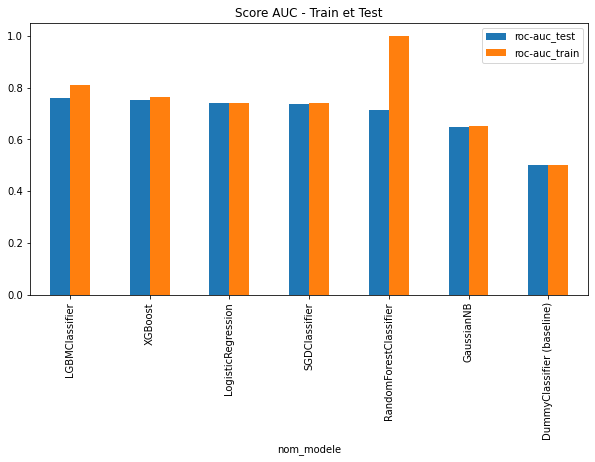

In [ ]:
fig = plt.figure(figsize=(10,5))

df_auc_graph = df_compare_score.sort_values(by="roc-auc_test", ascending=False)

axs1 = df_auc_graph.plot.bar(y={"roc-auc_train", "roc-auc_test"}, x="nom_modele", figsize=(10,5))
plt.xticks(rotation=90)
plt.title("Score AUC - Train et Test")
plt.show()

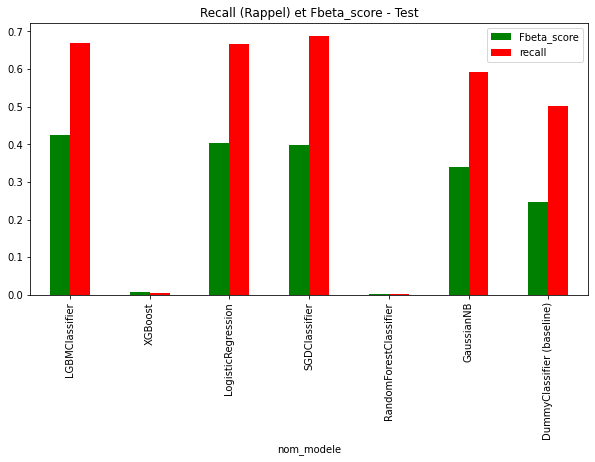

In [ ]:
axs2 = df_auc_graph.plot.bar(y={"recall", "Fbeta_score"}, x="nom_modele", rot=0, 
                       color={"recall":"red", "Fbeta_score":"green"}, figsize=(10,5))
plt.xticks(rotation=90)
plt.title("Recall (Rappel) et Fbeta_score - Test")
plt.show()

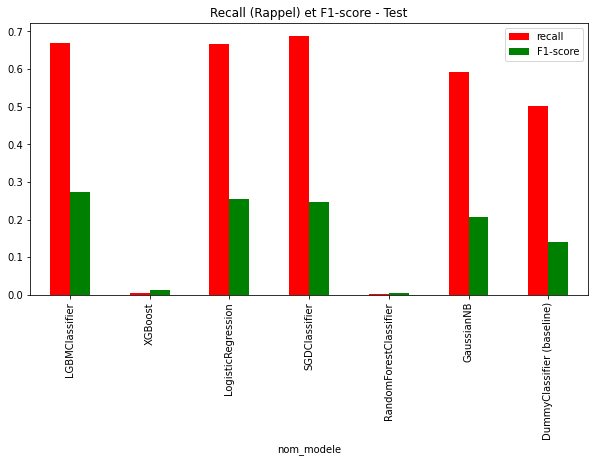

In [ ]:
axs2 = df_auc_graph.plot.bar(y={"recall", "F1-score"}, x="nom_modele", rot=0, 
                       color={"recall":"red", "F1-score":"green"}, figsize=(10,5))
plt.xticks(rotation=90)
plt.title("Recall (Rappel) et F1-score - Test")
plt.show()

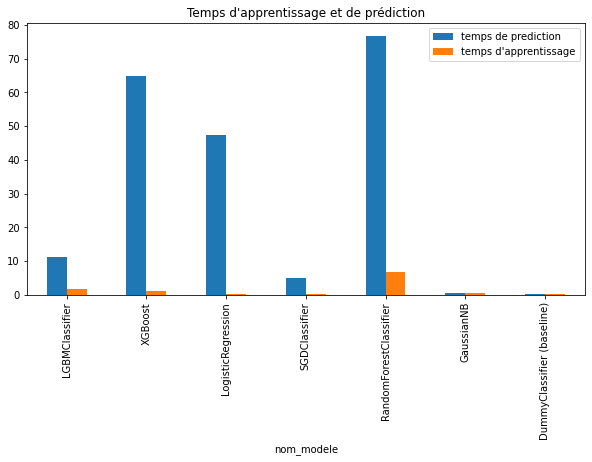

In [ ]:
axs3 = df_auc_graph.plot.bar(y={"temps de prediction", "temps d'apprentissage"}, x="nom_modele", rot=0, figsize=(10,5))
plt.xticks(rotation=90)
plt.title("Temps d'apprentissage et de prédiction")
plt.show()

In [ ]:
'''
from imblearn.over_sampling import BorderlineSMOTE

smote_borderline = BorderlineSMOTE(random_state=42)
x_train_smote_borderline, y_train_smote_borderline = smote_borderline.fit_resample(X_train, y_train)
'''

'\nfrom imblearn.over_sampling import BorderlineSMOTE\n\nsmote_borderline = BorderlineSMOTE(random_state=42)\nx_train_smote_borderline, y_train_smote_borderline = smote_borderline.fit_resample(X_train, y_train)\n'

In [ ]:
'''
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=7)
X_res_poly, y_res_poly = sm.fit_resample(X_train_poly, y_train_poly)
'''

"\nfrom imblearn.over_sampling import SMOTE\nsm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=7)\nX_res_poly, y_res_poly = sm.fit_resample(X_train_poly, y_train_poly)\n"

In [ ]:
'''
sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=7)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
'''

"\nsm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=7)\nX_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)\n"

## <center><font color=DarkBlue>5 - Optimisation et prédiction du meilleure modèle (LGBMClassifier)</font></center>

### <center><font color=DarkBlue>5.1 - GridSearchCV</font></center>

In [ ]:

model_lgbm = lgb.LGBMClassifier(random_state=random_state,class_weight=class_weight, 
                                objective="binary")
model_lgbm.get_params()


{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:

# Créer la recherche des hyperparamètres

params_grid_lgbm = {"n_estimators":[100, 500], 
                    "max_depth":[8, 12], 
                    "learning_rate":[0.01, 0.02], 
                    "num_leaves":[20, 30, 50]
                    }


# Créer le Grid Search
gscv_lgbm = GridSearchCV(model_lgbm, 
                         params_grid_lgbm, 
                         cv=cv, 
                         scoring=scoring, 
                         refit="fbeta_score",
                         verbose=True, 
                         n_jobs=-1)

# Lancer le Grid Search
best_lgbm = gscv_lgbm.fit(X_train, y_train)

# Visualiser les meilleures valeurs des hyperparamètres
print("Meilleur estimateur : ", best_lgbm.best_estimator_)
print("Meilleurs paramètres : ", best_lgbm.best_params_)
print("Meilleur score : ", best_lgbm.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Meilleur estimateur :  LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=12,
               n_estimators=500, num_leaves=30, objective='binary',
               random_state=42)
Meilleurs paramètres :  {'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 500, 'num_leaves': 30}
Meilleur score :  0.4232865711857951


### <center><font color=DarkBlue>5.3 - Prédiction</font></center>

In [ ]:
# Créer et entraîner le modèle final avec les paramètres optimisés
best_lgbm = lgb.LGBMClassifier(class_weight="balanced", 
                            objective="binary",
                            nthread=-1,
                            #device_type='gpu',
                            n_estimators=500,
                            learning_rate=0.02,
                            max_depth=12,
                            num_leaves=30,
                            colsample_bytree=0.613,
                            subsample=0.708,
                            max_bin=407,
                            reg_alpha=3.564,
                            reg_lambda=4.930,
                            min_child_weight=6,
                            min_child_samples=165,
                            #keep_training_booster=True,
                            silent=-1,
                            verbose=-1,
                            n_jobs=-1).fit(X_train, y_train)

# PREDICTIONS
# Prédire les valeurs binaires
y_pred_lgbm = best_lgbm.predict(X_test)
# Prédire les probabilités et retourner les résultats 1 uniquement
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:,1]

# EVALUATION

# Fbeta_score (avec plus de poids sur le rappel)
fbeta_lgbm = fbeta_score(y_test,  y_pred_lgbm, beta=2)
print("Fbeta_score - LGBMClassifier = %f \n" % (fbeta_lgbm))

# AUC
fp_lgbm, tp_lgbm, thresholds = roc_curve(y_test, y_proba_lgbm)
auc_lgbm = auc(fp_lgbm, tp_lgbm)
print("AUC - LGBMClassifier = %f \n" % (auc_lgbm))

# seuil
j_stat = tp_lgbm - fp_lgbm
index_for_best_threshold = np.argmax(j_stat)
best_threshold = thresholds[index_for_best_threshold]
print('le meilleur seuil :', best_threshold)

# Rapport de classification
classif_report_lgbm = classification_report(y_test, y_pred_lgbm)
print("Classification Report - LightGBM :\n", classif_report_lgbm)

# Matrice de confusion
confusion_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("Confusion Matrix - LightGBM :\n", pd.DataFrame(confusion_matrix_lgbm, 
                                                      columns=["prédit: 0","prédit: 1"], 
                                                      index=["réel : 0", "réel: 1"]))

Fbeta_score - LGBMClassifier = 0.431425 

AUC - LGBMClassifier = 0.768431 

le meilleur seuil : 0.4919596726394012
Classification Report - LightGBM :
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     56535
           1       0.17      0.69      0.28      4965

    accuracy                           0.71     61500
   macro avg       0.57      0.70      0.55     61500
weighted avg       0.90      0.71      0.77     61500

Confusion Matrix - LightGBM :
           prédit: 0  prédit: 1
réel : 0      40253      16282
réel: 1        1552       3413


In [ ]:
# Importer
from sklearn.metrics import precision_score
#  Précision parfaite 
score = precision_score(y_test, y_pred_lgbm)
print('Perfect Precision: %.3f' % score)

Perfect Precision: 0.173


In [ ]:
fbeta_lgbm_recall = fbeta_score(y_test,  y_pred_lgbm, beta=2) # 2, donne plus de poids au rappel
print('Score avec plus de poids au rappel',fbeta_lgbm_recall )
fbeta_lgbm_precision = fbeta_score(y_test,  y_pred_lgbm, beta=0.5) #0.5, donne plus de poids à la précision
print('Score avec plus de poids à la precision',fbeta_lgbm_precision )

Score avec plus de poids au rappel 0.4314245986600935
Score avec plus de poids à la precision 0.20377335960355838


Je peux modifier le seuil de probabilité au delà duquel les clients sont considérer comme non-solvable, afin d'en prédire la grande majorité, quitte à mal classer les clients solvables.

Plus le seuil est bas, plus la précision de la classe augmentera, mais le rappel diminuera

In [ ]:
import plotly.express as px
# les fbeta_scores
threshold_array = np.linspace(0, 1, 100)

fbeta_list = []
probs = best_lgbm.predict_proba(X_test)
for threshold in threshold_array:
    # Labels prédits pour un seuil donné
    label_pred_threshold = (probs[:,1] >= threshold).astype(int)
    # Calcul du fbeta_score pour un seuil donné
    fbeta_threshold = fbeta_score(y_test,  label_pred_threshold, beta=2)

    fbeta_list.append(fbeta_threshold)

fig = px.line(threshold_array,fbeta_list)

fig.update_layout(
                title={'text': 'fbeta_score par threshold',
                               'y':0.9,
                               'x':0.5,
                       'xanchor': 'center',
                       'yanchor': 'top'},
                xaxis_title='Fbeta_score',
                yaxis_title='Thresholds',
                showlegend=True)
fig.show()   

In [ ]:
threshold = 0.51
probs = best_lgbm.predict_proba(X_test)
pred_class = (probs[:,1] >= threshold).astype('int')

fbeta_lgbm = fbeta_score(y_test,  pred_class, beta=2)
print("Fbeta_score - LGBMClassifier = %f \n" % (fbeta_lgbm))

# Rapport de classification
classif_report_lgbm = classification_report(y_test, pred_class)
print("Classification Report - LightGBM :\n", classif_report_lgbm)

confusion_matrix_lgbm = confusion_matrix(y_test, pred_class)
print("Confusion Matrix - LightGBM :\n", pd.DataFrame(confusion_matrix_lgbm, 
                                                      columns=["prédit: 0","prédit: 1"], 
                                                      index=["réel : 0", "réel: 1"]))

Fbeta_score - LGBMClassifier = 0.431434 

Classification Report - LightGBM :
               precision    recall  f1-score   support

           0       0.96      0.72      0.83     56535
           1       0.18      0.67      0.28      4965

    accuracy                           0.72     61500
   macro avg       0.57      0.70      0.55     61500
weighted avg       0.90      0.72      0.78     61500

Confusion Matrix - LightGBM :
           prédit: 0  prédit: 1
réel : 0      40921      15614
réel: 1        1615       3350


#### <center><font color=DarkBlue>5.3.1 - Tableau des predictions</font></center>

In [ ]:
# Transformer X_train d'array en dataframe pour récupérer les noms des colonnes
X_test_df = pd.DataFrame(X_test, columns=X.columns)
#X_test_df['SK_ID_CURR'] = df_test['SK_ID_CURR']
X_test_df['REEL'] = y_test.values
X_test_df['PREDICTION'] = y_pred_lgbm
X_test_df['%_RISQUE_DEFAULT_PAIEMENT'] = np.round(y_proba_lgbm,2)
X_test_df['RESULTAT'] = X_test_df['PREDICTION'].apply(lambda x: 'REFUSEE' if x == 1 else 'ACCORDEE')

#df_pred = df_test.merge(X_test_df, how='inner', left_index=True)
df_pred = df_test.merge(X_test_df, how='left', left_index=True, right_index=True)
df_pred_filter = df_pred[['SK_ID_CURR','REEL','PREDICTION', 'RESULTAT', '%_RISQUE_DEFAULT_PAIEMENT']]
df_pred_filter

,SK_ID_CURR,REEL,PREDICTION,RESULTAT,%_RISQUE_DEFAULT_PAIEMENT
0,100001,0,1,REFUSEE,0.57
1,100005,1,0,ACCORDEE,0.43
2,100013,0,0,ACCORDEE,0.21
3,100028,1,0,ACCORDEE,0.11
4,100038,0,0,ACCORDEE,0.32
...,...,...,...,...,...
48739,456221,0,0,ACCORDEE,0.24
48740,456222,0,0,ACCORDEE,0.19
48741,456223,0,1,REFUSEE,0.75
48742,456224,0,0,ACCORDEE,0.47


Les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

Dans la cellule suivante, j'affiche les risques liés aux erreurs de faux négatifs et positifs

In [ ]:
df_mask=X_test_df['REEL']!= X_test_df['PREDICTION']
filtered_df = df_pred_filter[df_mask]
filtered_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,SK_ID_CURR,REEL,PREDICTION,RESULTAT,%_RISQUE_DEFAULT_PAIEMENT
0,100001,0,1,REFUSEE,0.57
1,100005,1,0,ACCORDEE,0.43
3,100028,1,0,ACCORDEE,0.11
6,100057,0,1,REFUSEE,0.50
8,100066,0,1,REFUSEE,0.57
...,...,...,...,...,...
48731,456123,0,1,REFUSEE,0.63
48735,456169,0,1,REFUSEE,0.67
48737,456189,0,1,REFUSEE,0.58
48738,456202,0,1,REFUSEE,0.60


Je constate que j'ai 14166 lignes qui présente des risques de faux négatif et faux positifs.

j'ai pu constater également que les vrais positifs ont un seuil compris entre 20% et 40% de risque de défaut de paiement.

Je vais créer un nouveau dataframe avec 3 valeurs pour la variable **<code>RESULTAT</code>** : 

- ACCORDEE *(valeur dont la prédiction est egale à 0)*
- REFUSEE *(valeurs dont la prédiction est egale à 1)*
- A ETUDIER *(toutes les valeurs qui présente des risques de faux positifs et de faux négatif)*



In [ ]:
for i in range(len(X_test_df)):
    if X_test_df['REEL'].loc[i] != X_test_df['PREDICTION'].loc[i]: 
        X_test_df.loc[i, 'RESULTAT'] = 'A ETUDIER'
    elif X_test_df['PREDICTION'].loc[i] == 1:
        X_test_df.loc[i,'RESULTAT'] = 'REFUSEE'
    else :
         X_test_df.loc[i, 'RESULTAT']  = 'ACCORDEE'


df_pred_X = df_test.merge(X_test_df, how='left', left_index=True, right_index=True)
df_pred_filter_X = df_pred_X[['SK_ID_CURR','REEL','PREDICTION', 'RESULTAT', '%_RISQUE_DEFAULT_PAIEMENT']]
df_pred_filter_X

,SK_ID_CURR,REEL,PREDICTION,RESULTAT,%_RISQUE_DEFAULT_PAIEMENT
0,100001,0,1,A ETUDIER,0.57
1,100005,1,0,A ETUDIER,0.43
2,100013,0,0,ACCORDEE,0.21
3,100028,1,0,A ETUDIER,0.11
4,100038,0,0,ACCORDEE,0.32
...,...,...,...,...,...
48739,456221,0,0,ACCORDEE,0.24
48740,456222,0,0,ACCORDEE,0.19
48741,456223,0,1,A ETUDIER,0.75
48742,456224,0,0,ACCORDEE,0.47


## <center><font color=DarkBlue>6 - Matrice de confusion, Courbe ROC et features importance</font></center>

In [ ]:
# Transformer X_train d'array en dataframe pour récupérer les noms des colonnes
X_train_df = pd.DataFrame(X_train, columns=X.columns)

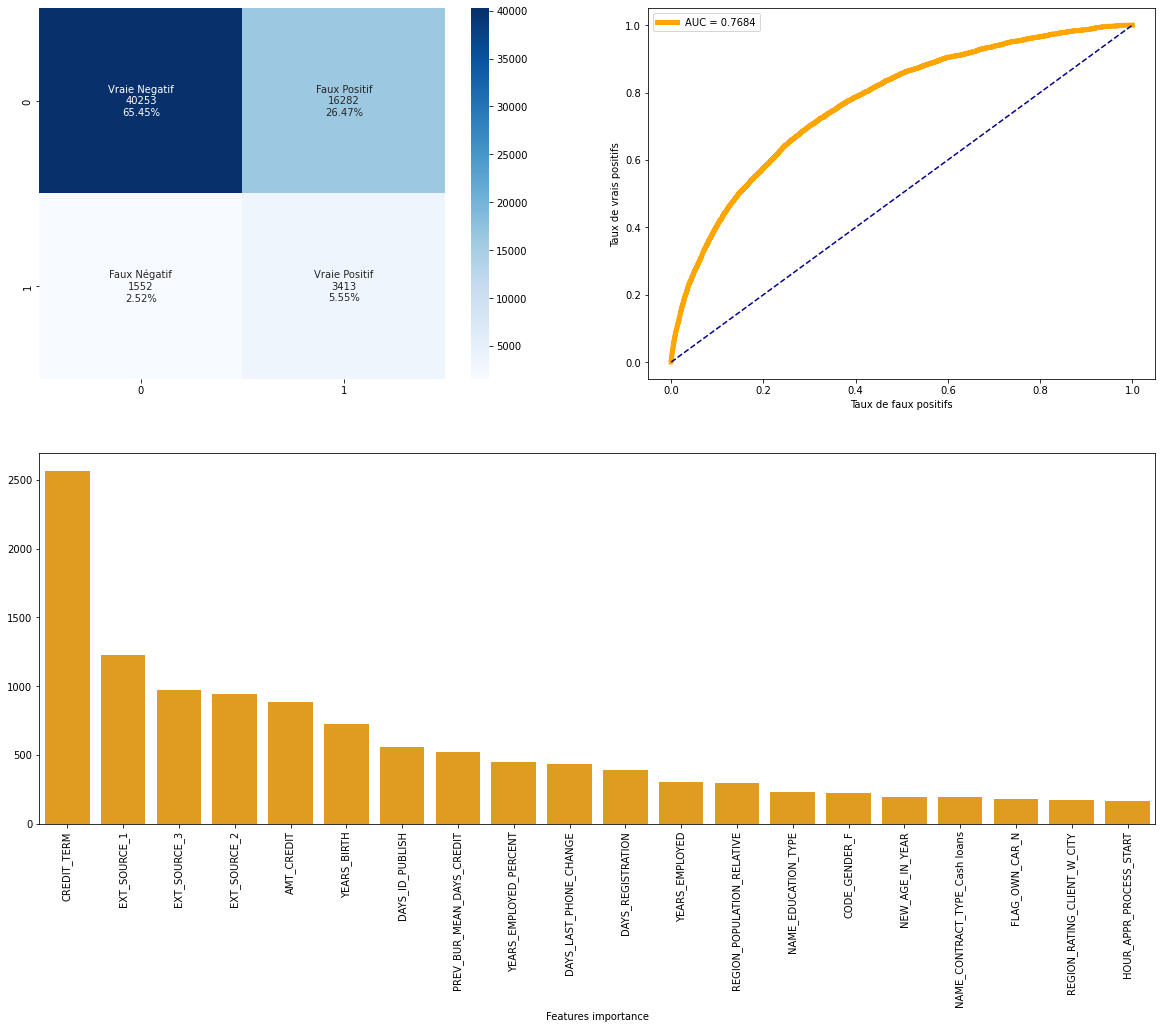

In [ ]:
cf_matrix_roc_auc(best_lgbm, y_test, y_pred_lgbm, y_proba_lgbm, X_train_df,feature_importances=True)

In [ ]:
#Check list features importance 
sorted_idx = np.argsort(best_lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train_df.columns[index], best_lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 2566]
['EXT_SOURCE_1', 1227]
['EXT_SOURCE_3', 974]
['EXT_SOURCE_2', 945]
['AMT_CREDIT', 884]
['YEARS_BIRTH', 723]
['DAYS_ID_PUBLISH', 561]
['PREV_BUR_MEAN_DAYS_CREDIT', 521]
['YEARS_EMPLOYED_PERCENT', 446]
['DAYS_LAST_PHONE_CHANGE', 431]
['DAYS_REGISTRATION', 389]
['YEARS_EMPLOYED', 300]
['REGION_POPULATION_RELATIVE', 293]
['NAME_EDUCATION_TYPE', 231]
['CODE_GENDER_F', 225]
['NEW_AGE_IN_YEAR', 194]
['NAME_CONTRACT_TYPE_Cash loans', 192]
['FLAG_OWN_CAR_N', 183]
['REGION_RATING_CLIENT_W_CITY', 171]
['HOUR_APPR_PROCESS_START', 163]
['NAME_FAMILY_STATUS_Married', 125]
['TOTALAREA_MODE', 122]
['FLAG_DOCUMENT_3', 115]
['APARTMENTS_MODE', 101]
['CODE_GENDER_M', 100]
['LIVINGAREA_MODE', 100]
['LIVINGAREA_MEDI', 95]
['APARTMENTS_AVG', 94]
['LIVINGAREA_AVG', 94]
['APARTMENTS_MEDI', 91]
['FLAG_WORK_PHONE', 86]
['OCCUPATION_TYPE_Core staff', 85]
['FLOORSMAX_AVG', 76]
['ORGANIZATION_TYPE_Self-employed', 73]
['REG_CITY_NOT_LIVE_CITY', 72]
['FLAG_OWN_CAR_Y', 70]
['OCCUPATION_TYPE_Driv

####<center><font color=DarkBlue>5.3.2 - Synthèses </font></center>

**<center>Tableau de synthèse</center>**

| **Indicateurs** | **Valeurs** | **Commentaires**
| :--- | :---: |:---: |
| **Fbeta_score** | 0,4316 |le modèle detecte 43 % de client non solvable.
| **AUC** | 0,7681 | il s'est amélioré : il est passé de 0,7584 à 0,768076
| **Recall** | 0.69 |le modèle fait des erreurs de **prédiction sur les Faux négatifs** de l'ordre de **31%**
| **Précision** | 0.17| le modèle fait des erreurs de **prédition sur les Faux positifs** de l'ordre de **83%** (rique de manque à gagner)

*A noter :*   

*- **Les faux négatifs** sont ceux qui sont classés comme SOLVABLE (qui peuvent rembourser) alors qu'ils sont NON-SOLVABLE*. 

*- **Les faux positifs** sont ceux qui sont classés NON-SOLVABLE, alors qu'ils sont SOLVABLE*

**les variables qui ont le plus d'impact sur le modèle sont :**

- **<code>CREDIT TERM</code>** = la durée de paiement en mois
- **<code>EXT SOURCE</code>** = Score de profil crédit acheté a des institutions financières 
- **<code>AMT CREDIT</code>**  = Le montant créditeur du prêt
- **<code>YEARS_BIRTH</code>**  = l'âge du client en années
- **<code>YEARS_EMPLOYED_PERCENT</code>**  = le pourcentage d'années employées par rapport à l'âge du client




## <center><font color=DarkBlue>7 - SHAP - Interpretabilité du modèle</font></center>

In [ ]:
import shap

# Charger la visualisation de code JS dans le notebook
shap.initjs()

### <center><font color=DarkBlue>7.2 - Expliquer les prédictions du modèle (Approche global)</font></center>

<center>Les méthodes d’interprétation globales permettent d’expliquer toutes les observations en même temps, globalement.</center>

In [ ]:
# INTERPRETATION DES PREDICTIONS DU MODELE
# Créer l'objet TreeExplainer pour expliquer l'arbre de décision
explainer = shap.TreeExplainer(best_lgbm, X_train, model_output="probability", feature_perturbation ="interventional")
shap_values = explainer.shap_values(X_train)

100%|===================| 245988/246000 [132:34<00:00]       

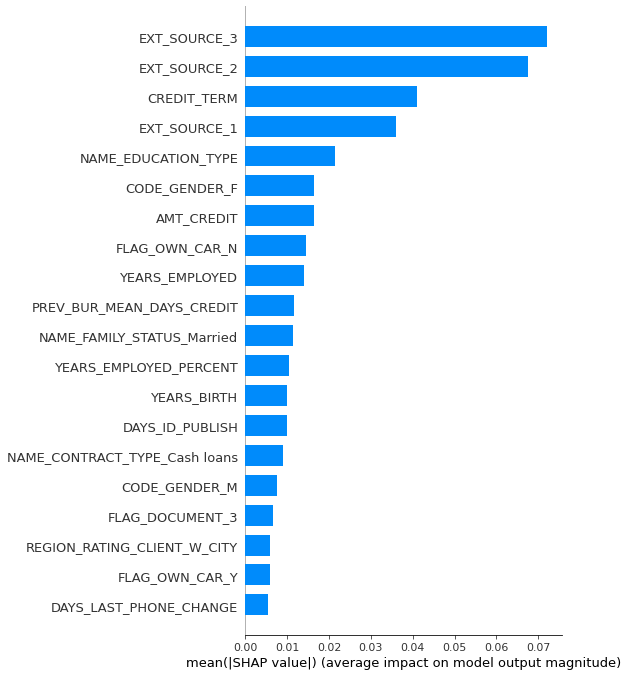

In [ ]:
shap.summary_plot(shap_values, X_train_df, plot_type="bar")

#### <center><font color=DarkBlue>7.3.1 - Diagramme d'importance variable</font></center>

le diagramme d'importance des variables répertorie **les variables les plus significatives** par ordre **décroissant.**
Les variables du **haut** contribuent davantage au modèle que celles du bas et ont donc un **pouvoir prédictif élevé.**

Le graphique de tracé récapitulatif **(summary_plot)** est l'un des graphiques les plus importants de la **bibliothèque SHAP** car il représente la distribution des 20 caractéristiques (variables) les plus importantes de notre modèle, et comment chacune d'elles affecte les résultats du modèle . 

Il affiche les informations suivantes :

- **Importance des caractéristiques** : les variables sont classées par ordre décroissant;
- **Impact** : l'emplacement horizontal indique si l'effet de cette valeur est associé à une prédiction supérieure ou inférieure;
- **Valeur d'origine** : la couleur indique si cette variable est **élevée** (en rouge) ou **faible** (en bleu) pour cette observation;
- **Corrélation** : 


**SHAP** calcule **l'importance de chaque variable** pour chaque donnée et fait **la moyenne de l'importance** pour obtenir **l'importance "globale"** de chaque variable.

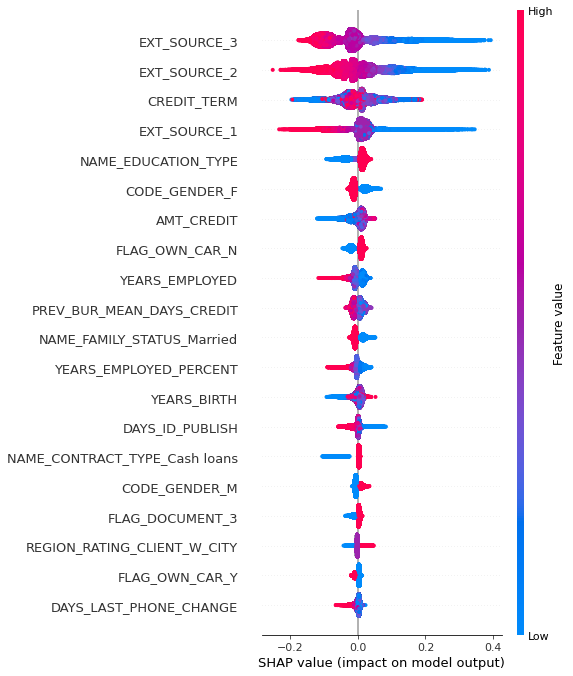

In [ ]:
shap.summary_plot(shap_values, X_train_df)

**Tracé simplifié :** la version simplifiée suivante pour une interprétation plus facile. 
Il met en évidence les corrélations de couleurs. La couleur rouge signifie qu'une caractéristique est positivement corrélée avec la variable cible. (source : https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

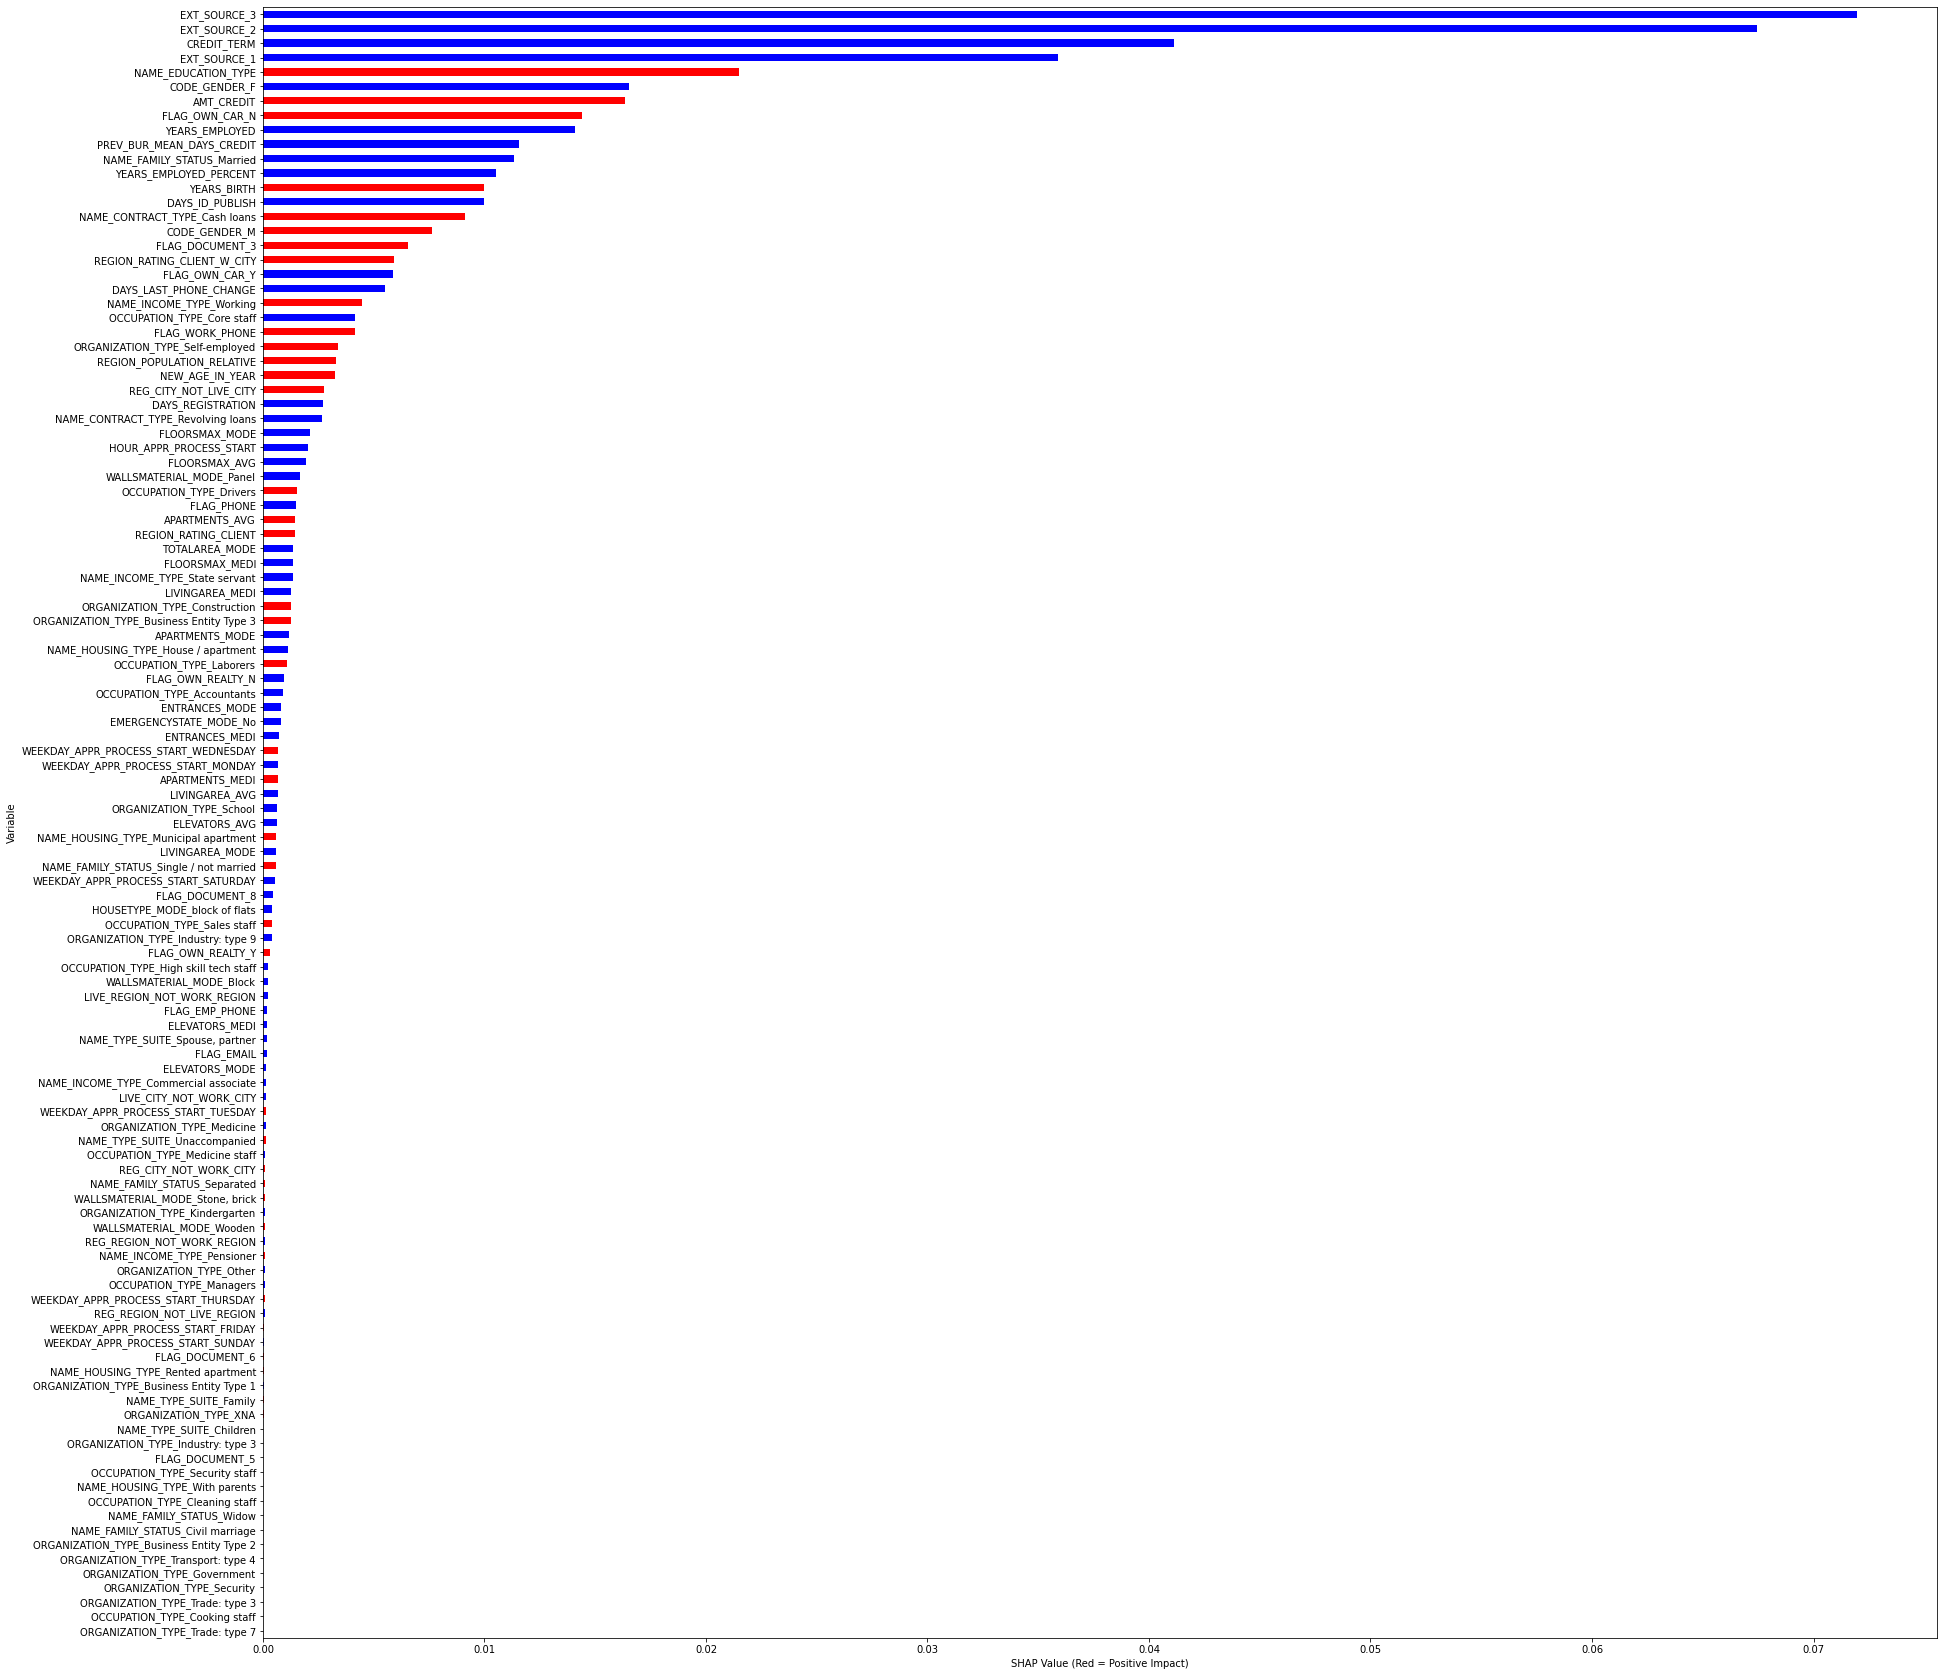

In [ ]:
ABS_SHAP(shap_values,X_train_df) 

### <center><font color=DarkBlue>7.4 - Explication - Tracé des valeurs SHAP individuelles (Approche locale)</font></center>

<center>Les méthodes d’interprétation locales donnent une interprétation pour un seul ou un petit nombre d’observations</center>

In [ ]:
# Tester sur la premiere observation (prediction = refuser)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train_df.iloc[0])

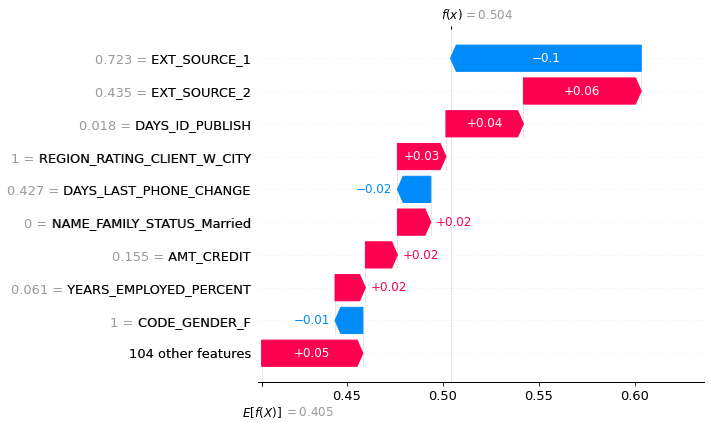

In [ ]:
# visualiser l'explication de la première prédiction
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], X_train_df.iloc[0])

In [ ]:
# Tester sur la troisième observation (prédiction accordée)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2], X_train_df.iloc[2])

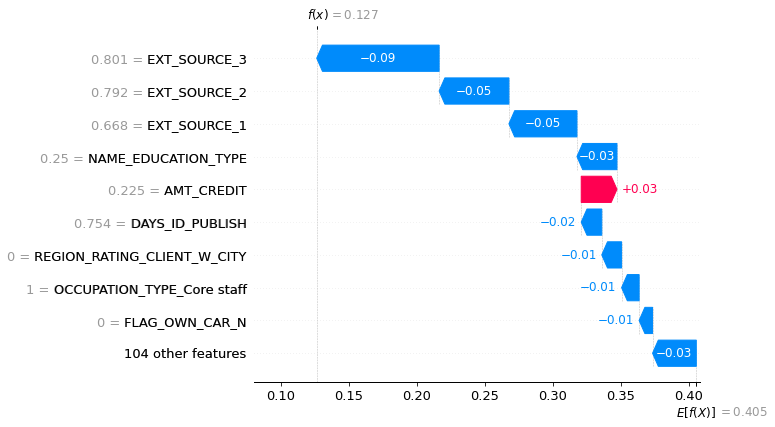

In [ ]:
# visualiser l'explication de la première prédiction
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[2], X_train_df.iloc[2])

## <center><font color=DarkBlue>7 - Conclusion</font></center>

La création d'un modèle d'apprentissage automatique nécessite de nombreuses transformations et ajustements. 

La méthodologie que j'ai utilisée pour la construction du modèle est la suivante:
- préparation des données; 
- Une compréhension des enjeux commerciaux; 
- choisir la metrique appropriée ; 
- gérer les données déséquilibrées dues à la présence de classes majoritaires et minoritaires ; 
- Testez plusieurs modèles et choisir le modèle final ; 
- Optimiser les hyperparamètres du modèle final ; 
- Interprétabilité du modèle 


le résultat du modèle dépend fortement des transformations et des traitements effectués, ainsi que du choix des paramètres de la méthode et du modèle lui-même.​​​

les performances peuvent être améliorer : 

- **Travailler avec le métier** pour acquérir une meilleure compréhension de l'entreprise afin que les données puissent être mieux préparées; 
- **Approfondir le mécanisme interne de chaque modèle** pour mieux optimiser les paramètres qui influent le modèle ; 
- **Essayez différentes techniques** pour la **sélection des fonctionnalités**, **le rééquilibrage des données (suréchantillonnage/sous-échantillonnage)**, d'autres outils d'interprétation (par exemple : **Lime** ); 
- **un meilleur ordre du code** pour optimiser les performances globales.